# Analisi su rischio infarto

Nel seguente paper, proveremo ad addestrare un modello basato sulla predizione della categoria di rischio in base allo stile di vita del paziente.
In particolare, verranno prese in considerazione le seguenti feature

In [36]:
import pandas as pd

df = pd.read_csv('dataset/mainDataset2.csv')
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Gender'] = pd.to_numeric(df['Gender'], errors='coerce')
df = df.dropna(subset=['Gender'])

features=[ 'Age', 'Gender', 'Smoking', 
          'Alcohol Consumption', 'Physical Activity Days Per Week', 
        'Stress Level', 'Obesity', 'Sleep Hours Per Day']

Y = df['Heart Attack Risk']
X=df[features]

X.head(4)

,Age,Gender,Smoking,Alcohol Consumption,Physical Activity Days Per Week,Stress Level,Obesity,Sleep Hours Per Day
0,0.595506,1,1.0,0.0,0.0,9.0,0.0,0.333333
1,0.595506,1,1.0,1.0,2.0,3.0,1.0,0.666667
2,0.595506,1,1.0,1.0,4.0,9.0,0.0,1.000000
3,0.078652,1,1.0,1.0,1.0,1.0,1.0,0.500000


Prima di procedere all'addestramento del modello, si evidenzia la sovrabbondanza di osservazioni che fanno parte della categoria di rischio 0.

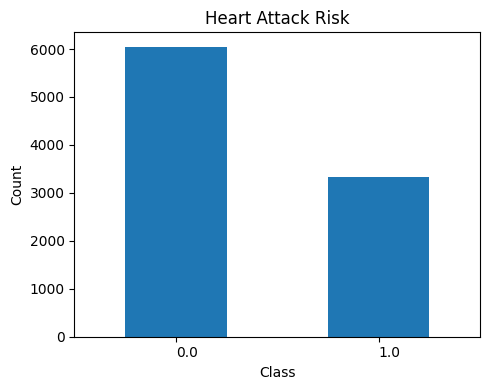

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
heart_attack_classes = df['Heart Attack Risk'].value_counts().sort_index()
heart_attack_classes.plot(kind='bar')
plt.title('Heart Attack Risk')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=0, ha='left')
plt.tight_layout()
plt.show()

Ciò provocherà un addestramento erroneo in seguito. Per ovviare al problema, verranno effettuate tecniche di undersampling e oversampling.

Prima di fare ciò, eseguiamo un'analisi statistica sul consumo di alcol e tabacco in correlazione alla categoria di rischio a cui ogni paziente appartiene.

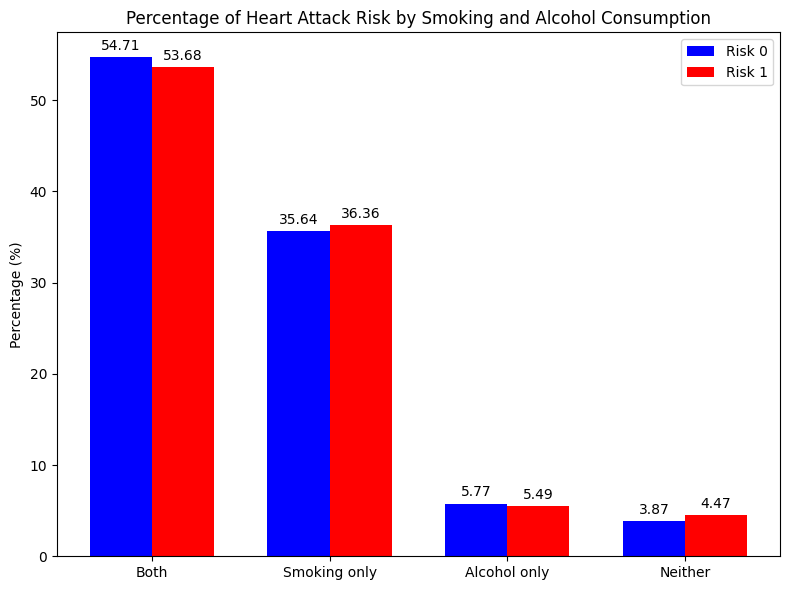

In [27]:
import numpy as np

dataset = X.copy()
dataset['Heart Attack Risk'] = Y

risk_counts_both = {}
risk_counts_smoking = {}
risk_counts_alcohol = {}
risk_counts_neither = {}
for risk_class in [0, 1]:
    count_both = dataset[
        (dataset['Smoking'] == 1) &
        (dataset['Alcohol Consumption'] == 1) &
        (dataset['Heart Attack Risk'] == risk_class)
    ].shape[0]
    count_smoking = dataset[
        (dataset['Smoking'] == 1) &
        (dataset['Alcohol Consumption'] == 0) &
        (dataset['Heart Attack Risk'] == risk_class)
    ].shape[0]
    count_alcohol = dataset[
        (dataset['Smoking'] == 0) &
        (dataset['Alcohol Consumption'] == 1) &
        (dataset['Heart Attack Risk'] == risk_class)
    ].shape[0]
    count_neither = dataset[
        (dataset['Smoking'] == 0) &
        (dataset['Alcohol Consumption'] == 0) &
        (dataset['Heart Attack Risk'] == risk_class)
    ].shape[0]
    risk_counts_both[risk_class] = count_both
    risk_counts_smoking[risk_class] = count_smoking
    risk_counts_alcohol[risk_class] = count_alcohol
    risk_counts_neither[risk_class] = count_neither

class_0_total = dataset[dataset['Heart Attack Risk'] == 0].shape[0]
class_1_total = dataset[dataset['Heart Attack Risk'] == 1].shape[0]

# Prepare data for plotting
labels = ['Both', 'Smoking only', 'Alcohol only', 'Neither']
counts_0 = [risk_counts_both[0]*100/class_0_total, 
            risk_counts_smoking[0]*100/class_0_total, 
            risk_counts_alcohol[0]*100/class_0_total, 
            risk_counts_neither[0]*100/class_0_total]
counts_1 = [risk_counts_both[1]*100/class_1_total, 
            risk_counts_smoking[1]*100/class_1_total, 
            risk_counts_alcohol[1]*100/class_1_total, 
            risk_counts_neither[1]*100/class_1_total]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, counts_0, width, label='Risk 0', color='blue')
rects2 = ax.bar(x + width/2, counts_1, width, label='Risk 1', color='red')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Heart Attack Risk by Smoking and Alcohol Consumption')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on bars with two decimal points
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dal grafico si nota che le due categorie di rischio, nonostante la differenza significativa di rappresentanza nel dataset, sono molto simili in base alle percentuali che fanno utilizzo delle sostanze sovracitate. Ciò, si evidenza, potrebbe non rispecchiare la popolazione reale.

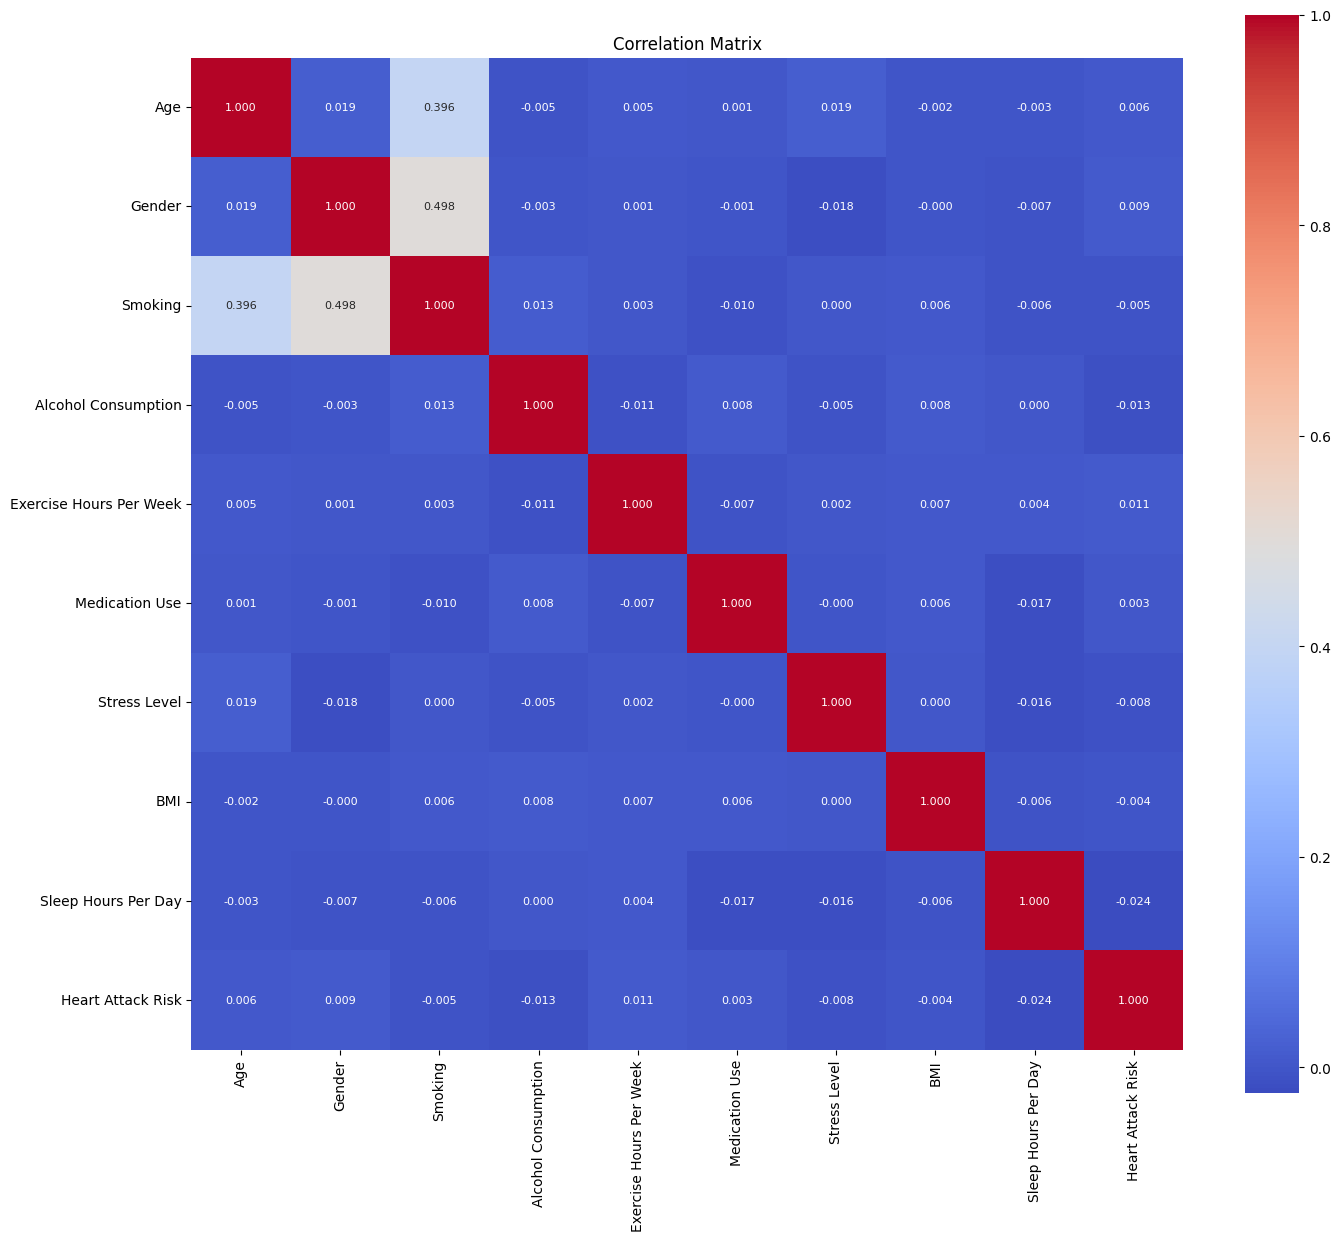

In [6]:
dataset.drop(columns=['color'], inplace=True)
correlation_matrix = dataset.corr()

plt.figure(figsize=(16, 14))  # Increase the figure size
import seaborn as sns
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".3f",            # Show only 2 decimal places
    cmap='coolwarm',
    square=True,
    annot_kws={'size': 8} # Smaller font for annotations
)
plt.title('Correlation Matrix')
plt.show()

Procediamo ora ad addestrare vari tipi di modelli. Prima di ciò, andiamo a svolgere, come citato in precedenza, azioni di undersampling e oversampling.

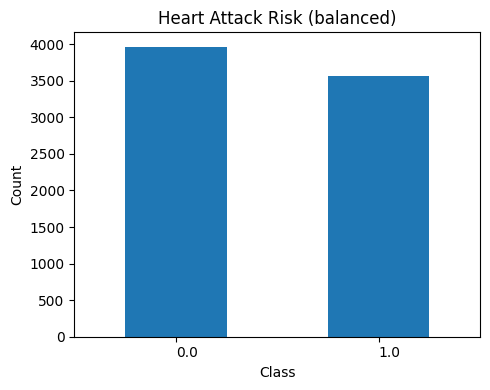

In [38]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42, sampling_strategy=0.85)
undersampler= RandomUnderSampler(random_state=42, sampling_strategy=0.9)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

X_balanced, Y_balanced = undersampler.fit_resample(X_train_smote, Y_train_smote)

plt.figure(figsize=(5, 4))
heart_attack_classes = Y_balanced.value_counts().sort_index()
heart_attack_classes.plot(kind='bar')
plt.title('Heart Attack Risk (balanced)')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=0, ha='left')
plt.tight_layout()
plt.show()

Si è deciso di mantenere comunque una leggera sovrarappresentazione della classe 0. Inoltre, questa bilanciatura è stata svolta sul solo set di addestramento

In [41]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_best = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42
)

rf_def = RandomForestClassifier(random_state=42)
rf_best.fit(X_balanced, Y_balanced)
rf_def.fit(X_balanced, Y_balanced)

from sklearn.metrics import classification_report

print("Random Forest Classifier (Default Parameters):")
print(classification_report(Y_test, rf_def.predict(X_test)))

print("Random Forest Classifier (Best Parameters):")
print(classification_report(Y_test, rf_best.predict(X_test)))

#XGBoost Classifier
xgb_best = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42
)
xgb_def = XGBClassifier(random_state=42)
xgb_best.fit(X_balanced, Y_balanced)
xgb_def.fit(X_balanced, Y_balanced)

print("XGBoost Classifier (Default Parameters):")
print(classification_report(Y_test, xgb_def.predict(X_test)))

print("XGBoost Classifier (Best Parameters):")
print(classification_report(Y_test, xgb_best.predict(X_test)))

#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(X_balanced, Y_balanced)
print("K-Nearest Neighbors Classifier:")
print(classification_report(Y_test, knn_best.predict(X_test)))





Random Forest Classifier (Default Parameters):
              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70      1848
         1.0       0.40      0.35      0.37       966

    accuracy                           0.59      2814
   macro avg       0.54      0.54      0.54      2814
weighted avg       0.58      0.59      0.59      2814

Random Forest Classifier (Best Parameters):
              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70      1848
         1.0       0.40      0.35      0.38       966

    accuracy                           0.60      2814
   macro avg       0.54      0.54      0.54      2814
weighted avg       0.59      0.60      0.59      2814

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70      1848
         1.0       0.40      0.35      0.38       966

    accuracy                           0.60      2814
   macro avg       0.54      0.54    